# Evaluation of Experiment Results
This notebook computes and visualizes results of experimental runs.

## Precision Extraction - Method Setup

In [1]:
from os import listdir
from os.path import exists, join
import json
import pandas as pd

DATA_PATH = "../data"
OUTPUT_PATH = "../output"

EXPERIMENTS = [
    "AvgDegreeCut",
    "EdgeMutationProbability",
    "EdgeMutationProbabilityExtreme",
    "NoImprovement",
]

DATASETS = [
    "Deco",
    "FusTe",
]


refined_data = {}
for dataset in DATASETS:
    refined_file_path = join(DATA_PATH, dataset, "refined.json")
    with open(refined_file_path) as f:
        refined_data[dataset] = json.load(f)
        
annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "annotations_elements.json")
    with open(annotations_file_path) as f:
        annotation_data[dataset] = json.load(f)

preprocessed_annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "preprocessed_annotations_elements.json")
    with open(annotations_file_path) as f:
        preprocessed_annotation_data[dataset] = json.load(f)

def is_multi_key(key, dataset):
    try:
        return refined_data[dataset][key]["table_count"] > 2
    except KeyError:
        tables = [region for region in annotation_data[dataset][key]["regions"] if region["region_type"] == "Table"]
        return len(tables) > 2

def get_edge_count(key, dataset):
    return refined_data[dataset][key]["edge_count"]

def file_accuracies(experiment_path):
    """Returns the file accuracies for this experiment"""
    file_accuracies = {}
    for fold_num in range(10):
        accuracy_file_path = join(
            experiment_path,   
            f"fold_{fold_num}",
            f"fold_{fold_num}_file_accuracies.json",
        )

        if not exists(accuracy_file_path):
            # Fold was aborted
            continue
        with open(accuracy_file_path) as f:
            fold_file_accuracies = json.load(f)["fold_file_accuracies"]
            for key, accuracy in fold_file_accuracies.items():
                file_accuracies[key] = accuracy
    return file_accuracies

def has_noise(experiment_path):
    config_file_path = join(
            experiment_path,   
            "config.json",
        )
    with open(config_file_path) as f:
        noise = json.load(f)["noise"]
    return bool(noise)

def get_experiment_paths(
    dataset,
    noise,
    experiment,
):
    if experiment not in EXPERIMENTS:
        raise ValueError("Unkown experiment")
        
    d = join(OUTPUT_PATH, experiment, dataset)
    experiments = listdir(d)
    experiment_paths = [
        join(d, exp)
        for exp in experiments
        if has_noise(join(d, exp)) == noise
    ]

    return experiment_paths

In [2]:
from statistics import mean, StatisticsError

def get_accuracies(dataset, noise, experiment):
    experiments = get_experiment_paths(dataset, noise, experiment)
    collected_accuracies = {}
    for exp in experiments:
        experimental_file_accuracies = file_accuracies(exp)
        for key, accuracy in experimental_file_accuracies.items():
            if accuracy > 1.0:
                print(key)
            collected_accuracies[key] = collected_accuracies.get(key, []) + [accuracy]

    all_accuracies = {"1_10": [], "10_100": [], ">100": []}
    single_accuracies = {"1_10": [], "10_100": [], ">100": []}
    multi_accuracies = {"1_10": [], "10_100": [], ">100": []}
    for key, accuracies in collected_accuracies.items():
        edge_count = get_edge_count(key, dataset)
        edge_count_key = "1_10"
        if edge_count > 100:
            edge_count_key = ">100"
        elif 10 < edge_count <= 100:
            edge_count_key = "10_100"

        m = mean(accuracies)
        all_accuracies[edge_count_key].append(m)
        if is_multi_key(key, dataset):
            multi_accuracies[edge_count_key].append(m)
        else:
            single_accuracies[edge_count_key].append(m)
    return all_accuracies, single_accuracies, multi_accuracies

In [20]:
def get_dataframe(dataset, noise, experiment):
    _data = get_accuracies(dataset, noise, experiment)
    acc_data = []
    for file_type in _data:
        data_row = []
        all_edge_counts = [item for l in file_type.values() for item in l]
        try:
            data_row.append(mean(all_edge_counts))
        except StatisticsError as e:
            print(f"{dataset} {noise} {experiment} {file_type}" + str(e))
            data_row.append(0)
            
        for edge_count, values in file_type.items():
            try:
                data_row.append(mean(values))
            except StatisticsError as e:
                # print(f"{dataset} {noise} {experiment}  {file_type} {edge_count}" + str(e))
                data_row.append(0)
        acc_data.append(data_row)
    return pd.DataFrame(acc_data, columns = ["All", "<10", "10<|E|<100", ">100"], index=["All", "Single", "Multi"])

## Evaluation

In [4]:
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

def plot_dataframe(dataset, noise, experiment):
    df = get_dataframe(dataset, noise, experiment)
    display(df.plot.bar(
        y=["<10", "10<|E|<100", ">100"],
        title=f"{dataset} - Noise: {noise} {experiment}",
        xlabel="File Type",
        ylabel="Accuracy",
        figsize=(6,3)
    ))

<AxesSubplot:title={'center':'Deco - Noise: True AvgDegreeCut'}, xlabel='File Type', ylabel='Accuracy'>

<AxesSubplot:title={'center':'Deco - Noise: True EdgeMutationProbability'}, xlabel='File Type', ylabel='Accuracy'>

<AxesSubplot:title={'center':'Deco - Noise: True EdgeMutationProbabilityExtreme'}, xlabel='File Type', ylabel='Accuracy'>

<AxesSubplot:title={'center':'Deco - Noise: True NoImprovement'}, xlabel='File Type', ylabel='Accuracy'>

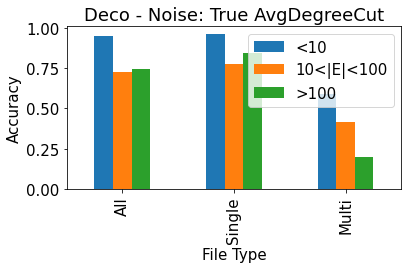

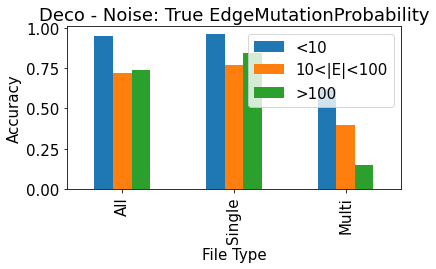

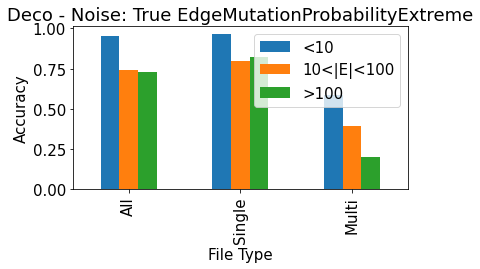

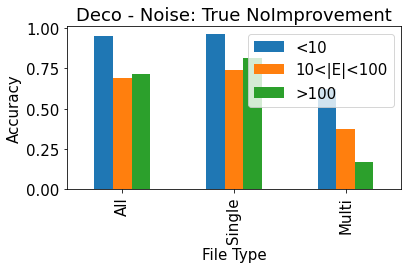

In [5]:
from IPython.display import display

dataset = "Deco"
noise = True

for experiment in EXPERIMENTS:
    plot_dataframe(dataset, noise, experiment)

FusTe True NoImprovement  {'1_10': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '10_100': [0.9523809523809523, 0.22222222222222224], '>100': []} >100mean requires at least one data point


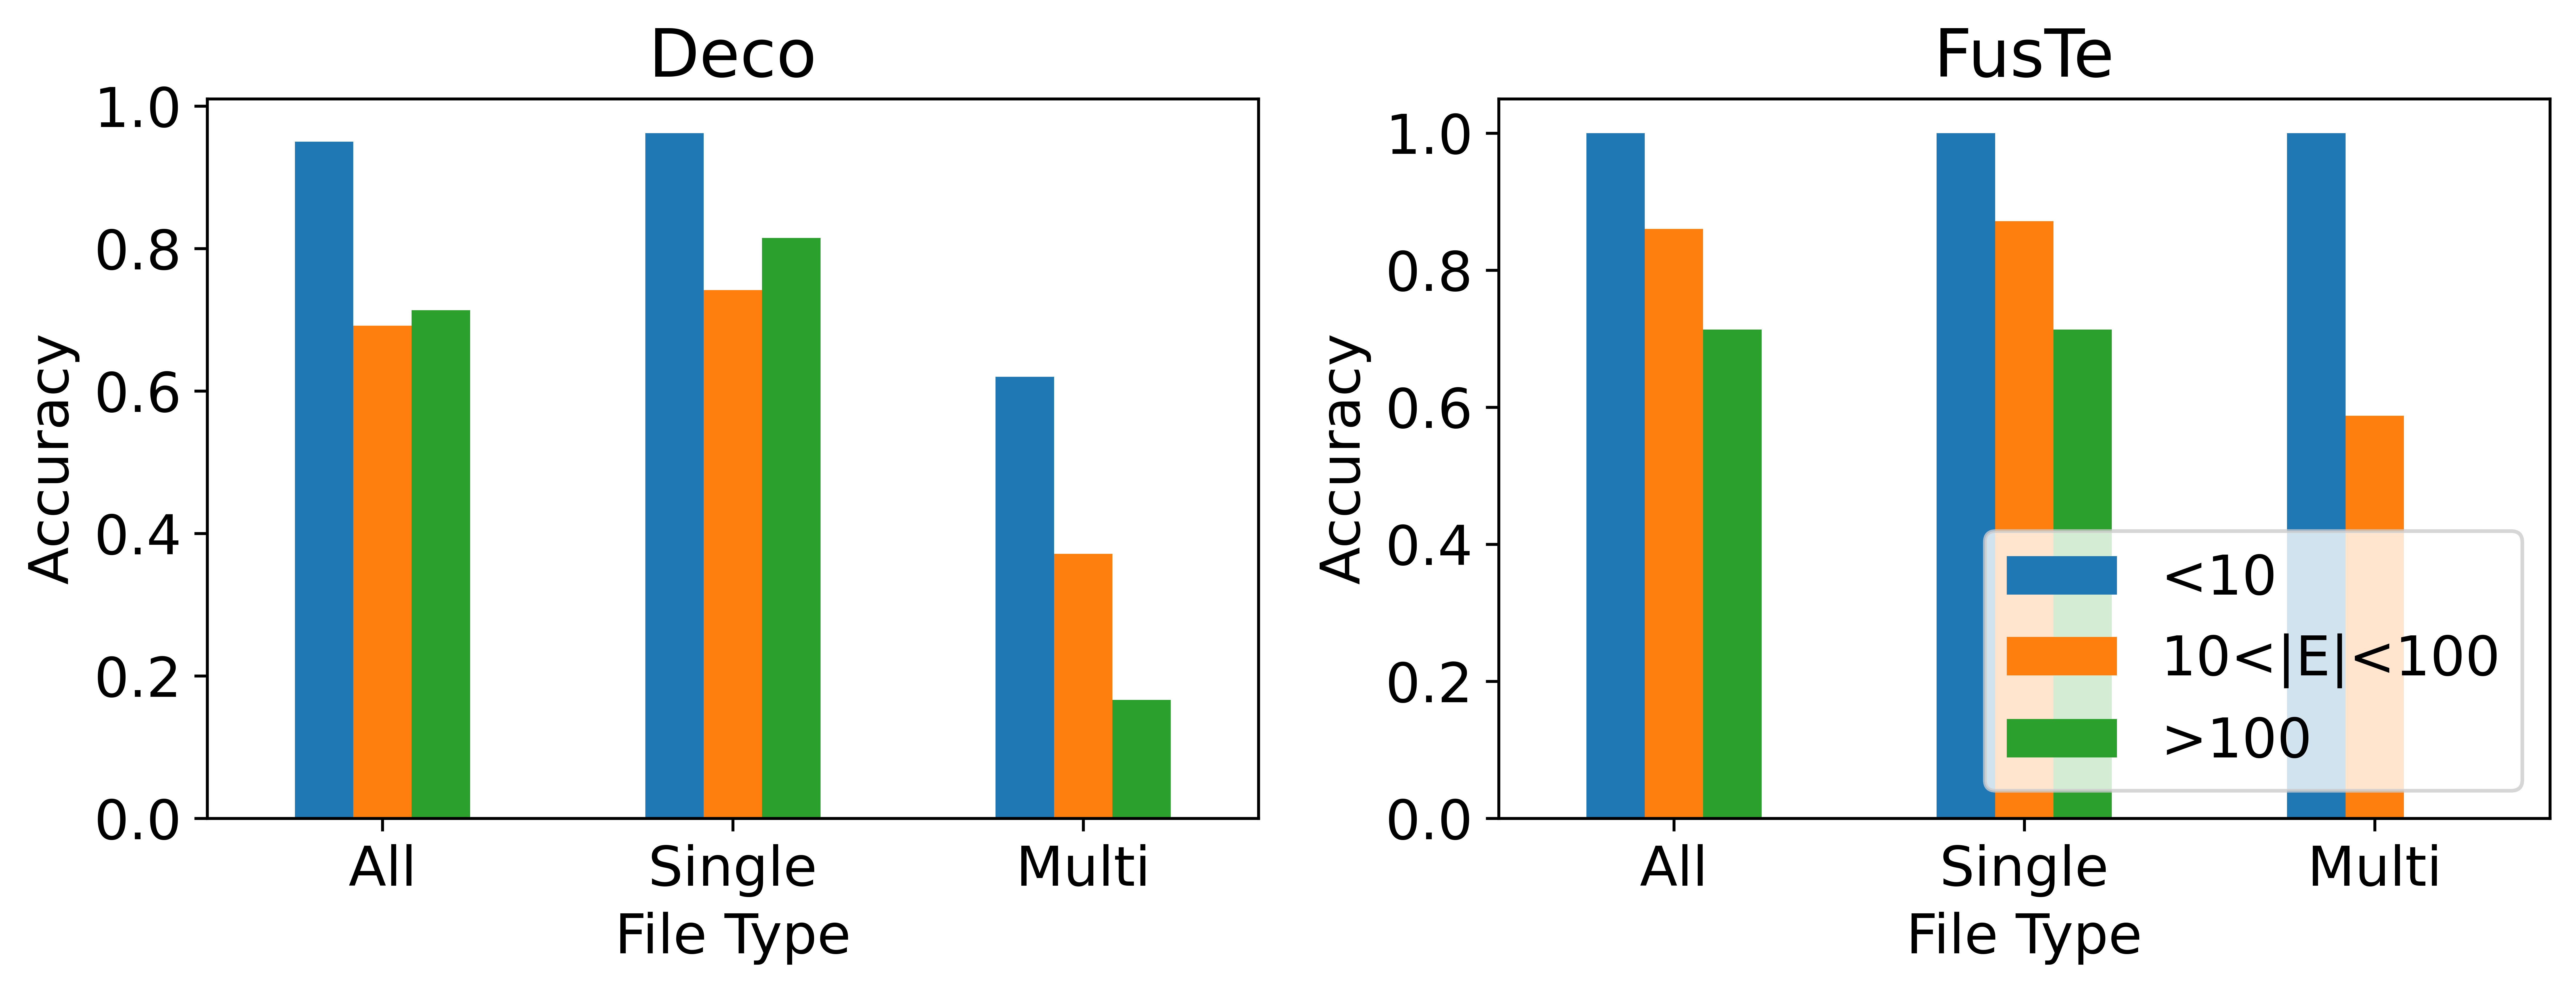

In [6]:
deco = get_dataframe("Deco", True, "NoImprovement")
fuste = get_dataframe("FusTe", True, "NoImprovement")


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), dpi=1024)
d = deco.plot.bar(
    y=["<10", "10<|E|<100", ">100"],
    title=f"Deco",
    xlabel="File Type",
    ylabel="Accuracy",
    ax=ax1,
    rot=0,
    legend=False,
)
f = fuste.plot.bar(
    y=["<10", "10<|E|<100", ">100"],
    title=f"FusTe",
    xlabel="File Type",
    ylabel="Accuracy",
    ax=ax2,
    rot=0,
)
ax2.legend(loc="lower right")
fig.tight_layout()

plt.show()

In [22]:
from pandas import DataFrame

matplotlib.rcParams.update({'font.size': 22})
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(17, 6), dpi=1024)


rows = []

experiment_lookup = dict(zip(EXPERIMENTS, [
    "adc",
    "emp",
    "emp-e",
    "original",
]))

for experiment in EXPERIMENTS:
    df = get_dataframe(dataset, noise, experiment)
    rows.append([experiment_lookup[experiment], df["All"]["Single"], df["All"]["Multi"]])

DataFrame(rows, columns=["Experiment", "Single", "Multi"]).plot.bar(
    x="Experiment",
    xlabel="Improvements",
    ylabel="Accuracy",
    title=f"{dataset} - Noise: {noise}",
    ax=ax1,
    rot=0,
)

original_single = get_dataframe(dataset, noise, "NoImprovement")["All"]["Single"]
original_multi = get_dataframe(dataset, noise, "NoImprovement")["All"]["Multi"]
ax1.axhline(y=original_single,linewidth=1, color='blue', linestyle='--')
ax1.axhline(y=original_multi,linewidth=1, color='red', linestyle='--')

# By Edge Count
rows = []
for experiment in EXPERIMENTS:
    df = get_dataframe(dataset, noise, experiment).transpose()
    rows.append([experiment_lookup[experiment], df["All"]["<10"], df["All"]["10<|E|<100"], df["All"][">100"]])
DataFrame(rows, columns=["Experiment", "<10", "10<|E|<100", ">100"]).plot.bar(
    x="Experiment",
    xlabel="Improvements",
    ylabel="Accuracy",
    title=f"{dataset} - Noise: {noise}",
    ax=ax2,
    rot=0,
)


df = get_dataframe(dataset, noise, "NoImprovement").transpose()
original_10 = df["All"]["<10"]
original_m = df["All"]["10<|E|<100"]
original_100 = df["All"][">100"]

ax2.axhline(y=original_10,linewidth=1, color='blue', linestyle='--')
ax2.axhline(y=original_m,linewidth=1, color='red', linestyle='--')
ax2.axhline(y=original_100,linewidth=1, color='darkgreen', linestyle='--')
ax2.legend(loc="lower right")




FusTe True AvgDegreeCut {'1_10': [], '10_100': [], '>100': []}mean requires at least one data point
FusTe True AvgDegreeCut {'1_10': [], '10_100': [], '>100': []}mean requires at least one data point
FusTe True AvgDegreeCut {'1_10': [], '10_100': [], '>100': []}mean requires at least one data point
FusTe True AvgDegreeCut {'1_10': [], '10_100': [], '>100': []}mean requires at least one data point
FusTe True AvgDegreeCut {'1_10': [], '10_100': [], '>100': []}mean requires at least one data point
FusTe True AvgDegreeCut {'1_10': [], '10_100': [], '>100': []}mean requires at least one data point
